# Ablation study: separation and distance encoding 

In [1]:
import yaml
import pandas as pd
from pathlib import Path
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

from proteins.config import flatten_dict

ix = pd.IndexSlice
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', 500)

## Import experiment results

In [2]:
from collections import defaultdict

df = defaultdict(list)
skip = []

for p in Path('.').glob('runs/*/experiment.latest.yaml'):
    with open(p) as ex:
        ex = yaml.safe_load(ex)
    if ex['history'][-1]['status'] != 'COMPLETED':
        skip.append(p)
    else:
        df['misc', 'tags', '', ''].append(','.join(ex['tags']))
        df['misc', 'comment', '', ''].append(ex.get('comment', None))
        df['misc', 'name', '', ''].append('_'.join(ex['fullname'].split('_')[-2:]))
        df['misc', 'time', '', ''].append((ex['history'][-1]['datetime_completed'] - ex['history'][-1]['datetime_started']).total_seconds() / 60)
        df['misc', 'gpu', '', ''].append(int(ex['history'][-1]['cuda']['devices']['cuda:0']['memory_used_max'].rstrip(' MiB')))
        df['hp', 'epochs', '', ''].append(ex['completed_epochs'])
        
        for k, v in flatten_dict(ex['data']):
            df[('hp', 'data', *k, '')].append(v)
            
        for k, v in flatten_dict(ex['model']):
            df[('hp', 'model', *k, '')].append(v)
            
        for k, v in flatten_dict(ex['optimizer']):
            df[('hp', 'optimizer', *k, '')].append(v)
        
        for k, v in flatten_dict(ex['loss']):
            df[('hp', 'loss', *k)].append(v)
        
        for k, v in flatten_dict(ex['history'][-1]['metric']):
            df[('metric', *k, '')].append(v)
                   
df = pd.DataFrame(df).sort_index(axis='columns', inplace=False)        
print(f'Skipped {len(skip)}')
print(f'Good {len(df)}')
df.iloc[0].to_frame('Example')

Skipped 0
Good 90


Example
hp     data         cutoff                      8                           
                    dssp                        True                        
                    partial_entropy             True                        
                    self_information            True                        
       epochs                                   35                          
       loss         global_gdtts        name    mse                         
                                        weight  1                           
                    local_lddt          name    mse                         
                                        weight  1                           
                    ranking             name    rank                        
                                        weight  0                           
       model        batch_norm                  False                       
                    distance_enc                rbf                         
                    dropout                     0.2                         
                    enc_in_edges                32                          
                    enc_in_nodes                125                         
                    fn                          proteins.networks.ProteinGN 
                    layers                      6                           
                    max_dist                    20                          
                    min_dist                    0                           
                    mp_in_edges                 128                         
                    mp_in_globals               512                         
                    mp_in_nodes                 512                         
                    mp_out_edges                16                          
                    mp_out_globals              32                          
                    mp_out_nodes                64                          
                    rbf_size                    32                          
                    residue_emb_size            64                          
                    separation_enc              absent                      
       optimizer    fn                          torch.optim.Adam            
                    lr                          0.001                       
                    weight_decay                1e-05                       
metric global_gdtts first_rank_loss             0.0648702                   
                    kendall                     0.740578                    
                    pearson                     0.913312                    
                    per_target_kendall          0.457006                    
                    per_target_pearson          0.738021                    
                    per_target_spearman         0.618353                    
                    ranking                     0.00870189                  
                    rmse                        0.112313                    
                    spearman                    0.91547                     
       local_lddt   pearson                     0.855557                    
                    per_model_pearson           0.580833                    
                    rmse                        0.12155                     
misc   comment                                  None                        
       gpu                                      2827                        
       name                                     vibrant_jackson             
       tags                                     ablation,sep_absent,dist_rbf
       time                                     145.739

For each encoding type, how many experiments do we have?

In [3]:
dtype_sep_enc = pd.CategoricalDtype(['Absent', 'Scalar', 'Categorical'], ordered=True)
dtype_dist_enc = pd.CategoricalDtype(['Absent', 'Scalar', 'RBF'], ordered=True)

df[('hp', 'model', 'separation_enc', '')] = df[('hp', 'model', 'separation_enc', '')].str.title().astype(dtype_sep_enc)
df[('hp', 'model', 'distance_enc', '')] = df[('hp', 'model', 'distance_enc', '')].map(lambda v: 'RBF' if v == 'rbf' else v.title()).astype(dtype_dist_enc)

In [4]:
df_counts = df.groupby([('hp','model','separation_enc'), ('hp','model','distance_enc')]).size() \
    .rename_axis(index=['Separation Enc', 'Distance Enc']) \
    .unstack(1)
display(df_counts)
del df_counts

Distance Enc,Absent,Scalar,RBF
Separation Enc,,,
Absent,10,10,10
Scalar,10,10,10
Categorical,10,10,10


Distance Enc,Absent,Scalar,RBF
Separation Enc,,,
Absent,0.067 ± 0.004,0.069 ± 0.005,0.062 ± 0.004
Scalar,0.065 ± 0.003,0.063 ± 0.006,0.062 ± 0.006
Categorical,0.064 ± 0.005,0.067 ± 0.003,0.063 ± 0.004


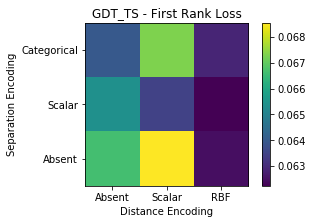

Distance Enc,Absent,Scalar,RBF
Separation Enc,,,
Absent,0.725 ± 0.01,0.727 ± 0.012,0.733 ± 0.005
Scalar,0.738 ± 0.006,0.729 ± 0.015,0.741 ± 0.006
Categorical,0.741 ± 0.005,0.732 ± 0.006,0.743 ± 0.007


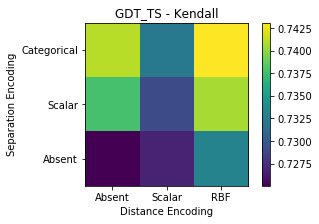

Distance Enc,Absent,Scalar,RBF
Separation Enc,,,
Absent,0.903 ± 0.006,0.904 ± 0.008,0.909 ± 0.004
Scalar,0.91 ± 0.004,0.901 ± 0.012,0.909 ± 0.005
Categorical,0.913 ± 0.003,0.906 ± 0.006,0.913 ± 0.005


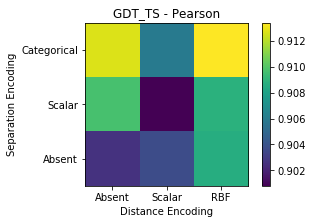

Distance Enc,Absent,Scalar,RBF
Separation Enc,,,
Absent,0.433 ± 0.006,0.434 ± 0.009,0.447 ± 0.008
Scalar,0.447 ± 0.007,0.445 ± 0.006,0.446 ± 0.006
Categorical,0.451 ± 0.008,0.447 ± 0.009,0.458 ± 0.007


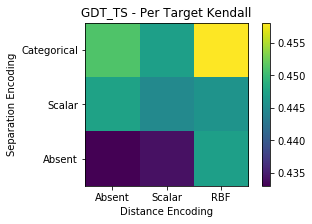

Distance Enc,Absent,Scalar,RBF
Separation Enc,,,
Absent,0.709 ± 0.01,0.71 ± 0.015,0.716 ± 0.015
Scalar,0.729 ± 0.009,0.723 ± 0.01,0.722 ± 0.008
Categorical,0.725 ± 0.013,0.722 ± 0.012,0.732 ± 0.01


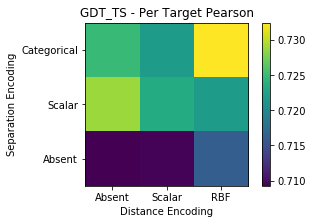

Distance Enc,Absent,Scalar,RBF
Separation Enc,,,
Absent,0.588 ± 0.008,0.59 ± 0.012,0.606 ± 0.01
Scalar,0.605 ± 0.009,0.602 ± 0.007,0.603 ± 0.007
Categorical,0.609 ± 0.01,0.605 ± 0.012,0.618 ± 0.009


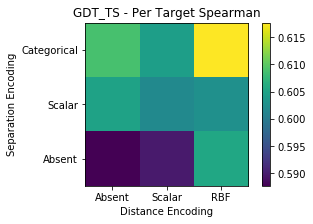

Distance Enc,Absent,Scalar,RBF
Separation Enc,,,
Absent,0.009 ± 0.0,0.009 ± 0.0,0.009 ± 0.0
Scalar,0.008 ± 0.0,0.009 ± 0.001,0.008 ± 0.0
Categorical,0.008 ± 0.0,0.008 ± 0.001,0.008 ± 0.0


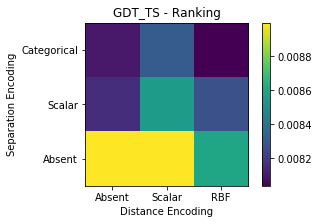

Distance Enc,Absent,Scalar,RBF
Separation Enc,,,
Absent,0.116 ± 0.003,0.117 ± 0.005,0.116 ± 0.007
Scalar,0.112 ± 0.004,0.118 ± 0.01,0.115 ± 0.006
Categorical,0.111 ± 0.004,0.118 ± 0.007,0.112 ± 0.004


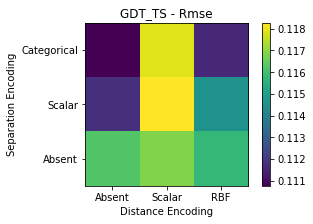

Distance Enc,Absent,Scalar,RBF
Separation Enc,,,
Absent,0.904 ± 0.008,0.906 ± 0.008,0.91 ± 0.004
Scalar,0.914 ± 0.004,0.907 ± 0.011,0.916 ± 0.004
Categorical,0.916 ± 0.003,0.91 ± 0.004,0.917 ± 0.004


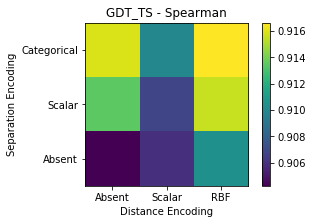

Distance Enc,Absent,Scalar,RBF
Separation Enc,,,
Absent,0.847 ± 0.005,0.85 ± 0.006,0.852 ± 0.006
Scalar,0.858 ± 0.005,0.848 ± 0.015,0.859 ± 0.005
Categorical,0.857 ± 0.004,0.853 ± 0.004,0.86 ± 0.005


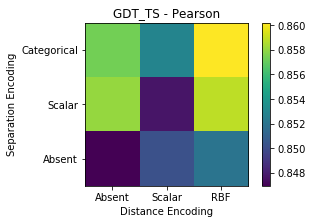

Distance Enc,Absent,Scalar,RBF
Separation Enc,,,
Absent,0.576 ± 0.004,0.578 ± 0.004,0.579 ± 0.007
Scalar,0.598 ± 0.004,0.591 ± 0.011,0.596 ± 0.008
Categorical,0.593 ± 0.003,0.592 ± 0.003,0.596 ± 0.006


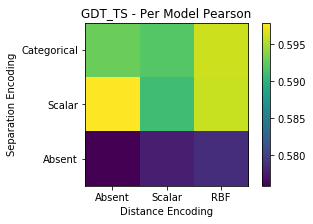

Distance Enc,Absent,Scalar,RBF
Separation Enc,,,
Absent,0.125 ± 0.002,0.124 ± 0.003,0.123 ± 0.003
Scalar,0.12 ± 0.002,0.126 ± 0.011,0.12 ± 0.001
Categorical,0.121 ± 0.002,0.123 ± 0.002,0.119 ± 0.002


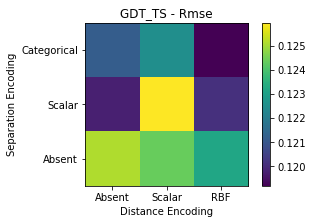

In [5]:
df_mean = df.groupby([('hp','model','separation_enc', ''), ('hp','model','distance_enc', '')]) \
    .apply(lambda group: group.metric.droplevel(2, axis=1).mean()) \
    .rename_axis(index=['Separation Enc', 'Distance Enc'], columns=['Output', 'Metric'])

df_std = df.groupby([('hp','model','separation_enc', ''), ('hp','model','distance_enc', '')]) \
    .apply(lambda group: group.metric.droplevel(2, axis=1).std()) \
    .rename_axis(index=['Separation Enc', 'Distance Enc'], columns=['Output', 'Metric'])

for column in df_mean.columns:
    title = f'{"LDDT" if "ldtt" in column[0] else "GDT_TS"} - {column[1].replace("_", " ").title()}'
    df_group = df_mean[column].unstack(1)
    display((
        df_mean[column].unstack(1).round(3).astype(str) + ' ± ' + 
        df_std[column].unstack(1).round(3).astype(str)
    ).style.set_caption(f'<h3>{title}</h3>'))
    
    fig, ax = plt.subplots(1, 1, figsize=(5, 3))
    
    im=ax.imshow(df_group.values, origin='lower')
    ax.set_title(title)
    ax.set_xlabel('Distance Encoding')
    ax.set_xticks(range(len(df_group.columns)))
    ax.set_xticklabels(df_group.columns)
    
    ax.set_ylabel('Separation Encoding')
    ax.set_yticks(range(len(df_group.index)))
    ax.set_yticklabels(df_group.index)
    
    plt.colorbar(im, ax=ax)
    fig.set_facecolor('white')
    display(fig)
    plt.close(fig)

## Separation encoding only (distance fixed to RBF)

For each encoding type, how many experiments do we have?

In [6]:
df_counts = df[df[('hp','model','distance_enc', '')] == 'RBF'] \
    .groupby(('hp','model','separation_enc')) \
    .size() \
    .to_frame('Count') \
    .rename_axis(index='Separation Encoding')
display(df_counts.sort_index())
del df_counts

,Count
Separation Encoding,
Absent,10
Scalar,10
Categorical,10


### GDT_TS: Per Target Pearson

,mean,std
Separation Encoding,,
Absent,0.711651,0.013443
Scalar,0.724816,0.009191
Categorical,0.726486,0.012093


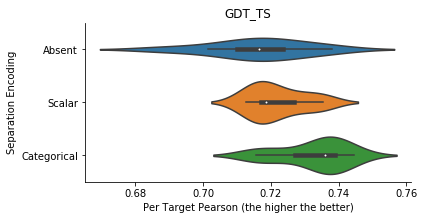

### LDDT: Per Model Pearson

,mean,std
Separation Encoding,,
Absent,0.577437,0.005163
Scalar,0.595068,0.008242
Categorical,0.593803,0.004461


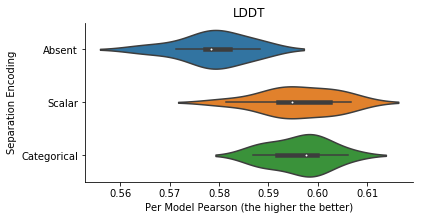

### GDT_TS: RMSE

,mean,std
Separation Encoding,,
Absent,0.116282,0.005101
Scalar,0.114892,0.007154
Categorical,0.113428,0.006217


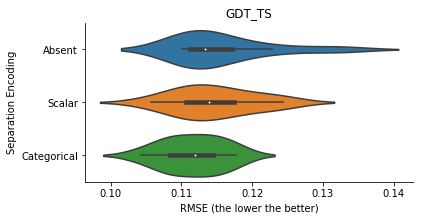

### LDDT: RMSE

,mean,std
Separation Encoding,,
Absent,0.124239,0.002898
Scalar,0.121955,0.006854
Categorical,0.120967,0.002390


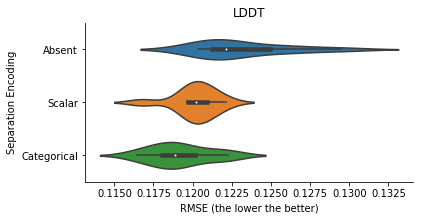

### GDT_TS: First Rank Loss

,mean,std
Separation Encoding,,
Absent,0.065887,0.004881
Scalar,0.063707,0.005153
Categorical,0.064740,0.004589


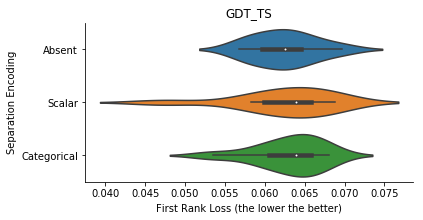

In [7]:
for title, slicer in {
    ('GDT_TS','Per Target Pearson'): ('global_gdtts','per_target_pearson',''),
    ('LDDT','Per Model Pearson'): ('local_lddt','per_model_pearson',''),
    ('GDT_TS','RMSE'): ('global_gdtts','rmse',''),
    ('LDDT','RMSE'): ('local_lddt','rmse',''),
    ('GDT_TS','First Rank Loss'): ('global_gdtts','first_rank_loss',''),
}.items():
    b = sns.catplot(
        y=('hp','model','separation_enc',''),
        x=('metric', *slicer),
        data=df[df[('hp','model','distance_enc', '')] == 'RBF'],
        kind="violin", 
        aspect=2,
        height=3,
    )
    b.fig.set_facecolor('white')
    b.ax.set_yticklabels([t._text.title() for t in b.ax.get_yticklabels()])
    b.ax.set_ylabel('Separation Encoding')
    b.ax.set_title(title[0])
    b.ax.set_xlabel(title[1] + (' (the lower the better)' if 'Loss' in title[1] or 'RMSE' in title[1] else ' (the higher the better)'))
    
    display(Markdown(f'### {title[0]}: {title[1]}'))
    display(df.groupby(('hp','model','separation_enc','')).agg(['mean', 'std'])[('metric', *slicer)].rename_axis(index='Separation Encoding'))
    
    b.fig.savefig(f'./separation_encoding_{title[0]}_{slicer[1]}.pdf', bbox_inches='tight', pad_inches=0.01)
    display(b.fig)
    plt.close(b.fig)

Figure for paper

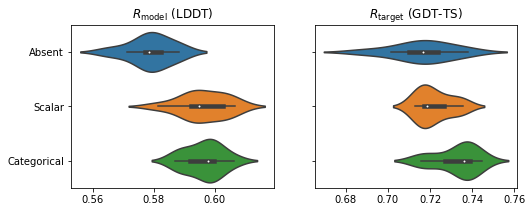

In [16]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(8, 3))

ax = axes[0]
sns.violinplot(
    y=('hp','model','separation_enc',''),
    x=('metric', 'local_lddt','per_model_pearson',''),
    data=df[df[('hp','model','distance_enc', '')] == 'RBF'],
    ax=ax,
)
ax.set_title(r'$R_\mathrm{model}$ (LDDT)')
ax.set_xlabel(None)
ax.set_ylabel(None)

ax = axes[1]
sns.violinplot(
    y=('hp','model','separation_enc',''),
    x=('metric', 'global_gdtts','per_target_pearson',''),
    data=df[df[('hp','model','distance_enc', '')] == 'RBF'],
    ax=ax,
)
ax.set_title(r'$R_\mathrm{target}$ (GDT-TS)')
ax.set_xlabel(None)
ax.set_ylabel(None)

fig.set_facecolor('white')
fig.savefig(f'./separation_encoding.pdf', bbox_inches='tight', pad_inches=0.01)
display(fig)
plt.close(fig)

## Distance encoding only (separation fixed to categorical)

For each encoding type, how many experiments do we have?

In [17]:
df_counts = df[df[('hp','model','separation_enc', '')] == 'Categorical'] \
    .groupby(('hp','model','distance_enc')) \
    .size() \
    .to_frame('Count') \
    .rename_axis(index='Distance Encoding')
display(df_counts.sort_index())
del df_counts

,Count
Distance Encoding,
Absent,10
Scalar,10
RBF,10


### GDT_TS: Per Target Pearson

,mean,std
Distance Encoding,,
Absent,0.721073,0.013388
Scalar,0.718341,0.013836
RBF,0.723538,0.012782


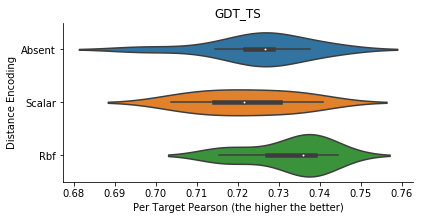

### LDDT: Per Model Pearson

,mean,std
Distance Encoding,,
Absent,0.588933,0.010204
Scalar,0.587004,0.009483
RBF,0.590371,0.010708


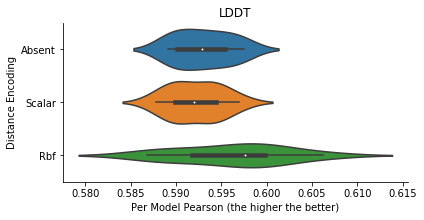

### GDT_TS: RMSE

,mean,std
Distance Encoding,,
Absent,0.112933,0.004375
Scalar,0.117677,0.007371
RBF,0.113991,0.005809


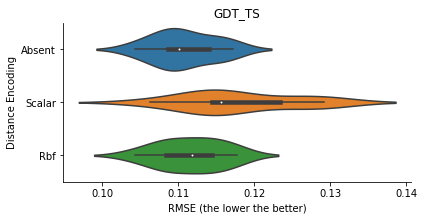

### LDDT: RMSE

,mean,std
Distance Encoding,,
Absent,0.122042,0.003079
Scalar,0.124283,0.006611
RBF,0.120837,0.002720


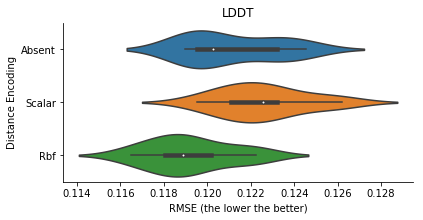

### GDT_TS: First Rank Loss

,mean,std
Distance Encoding,,
Absent,0.065351,0.004231
Scalar,0.066452,0.004939
RBF,0.062531,0.004810


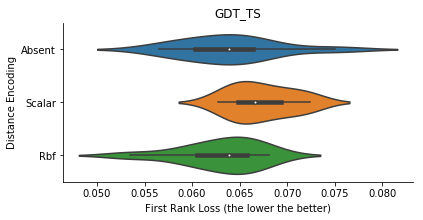

In [18]:
for title, slicer in {
    ('GDT_TS','Per Target Pearson'): ('global_gdtts','per_target_pearson',''),
    ('LDDT','Per Model Pearson'): ('local_lddt','per_model_pearson',''),
    ('GDT_TS','RMSE'): ('global_gdtts','rmse',''),
    ('LDDT','RMSE'): ('local_lddt','rmse',''),
    ('GDT_TS','First Rank Loss'): ('global_gdtts','first_rank_loss',''),
}.items():
    b = sns.catplot(
        y=('hp','model','distance_enc',''),
        x=('metric', *slicer),
        data=df[df[('hp','model','separation_enc', '')] == 'Categorical'],
        kind="violin", 
        aspect=2,
        height=3,
    )
    b.fig.set_facecolor('white')
    b.ax.set_yticklabels([t._text.title() for t in b.ax.get_yticklabels()])
    b.ax.set_ylabel('Distance Encoding')
    b.ax.set_title(title[0])
    b.ax.set_xlabel(title[1] + (' (the lower the better)' if 'Loss' in title[1] or 'RMSE' in title[1] else ' (the higher the better)'))
    
    display(Markdown(f'### {title[0]}: {title[1]}'))
    display(df.groupby(('hp','model','distance_enc','')).agg(['mean', 'std'])[('metric', *slicer)].rename_axis(index='Distance Encoding'))
    
    b.fig.savefig(f'./distance_encoding_{title[0]}_{slicer[1]}.pdf', bbox_inches='tight', pad_inches=0.01)
    display(b.fig)
    plt.close(b.fig)

Figure for paper

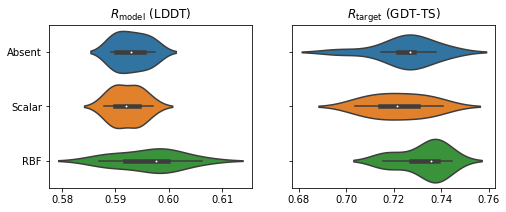

In [19]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(8, 3))

ax = axes[0]
sns.violinplot(
    y=('hp','model','distance_enc',''),
    x=('metric', 'local_lddt','per_model_pearson',''),
    data=df[df[('hp','model','separation_enc', '')] == 'Categorical'],
    ax=ax,
)
ax.set_title(r'$R_\mathrm{model}$ (LDDT)')
ax.set_xlabel(None)
ax.set_ylabel(None)

ax = axes[1]
sns.violinplot(
    y=('hp','model','distance_enc',''),
    x=('metric', 'global_gdtts','per_target_pearson',''),
    data=df[df[('hp','model','separation_enc', '')] == 'Categorical'],
    ax=ax,
)
ax.set_title(r'$R_\mathrm{target}$ (GDT-TS)')
ax.set_xlabel(None)
ax.set_ylabel(None)

fig.set_facecolor('white')
fig.savefig(f'./distance_encoding.pdf', bbox_inches='tight', pad_inches=0.01)
display(fig)
plt.close(fig)